## **0. Install dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install boto3 jsonnet jsonpickle tensorboardX conllu overrides word2number py-rouge
!pip install --no-deps allennlp==1.1.0 allennlp_models==1.1.0

In [ ]:
!pip install \
transformers==3.0.1 \
seqeval \
tqdm \
flair \
sklearn_crfsuite \
nltk

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **1. Sequence Tagging Groundings**

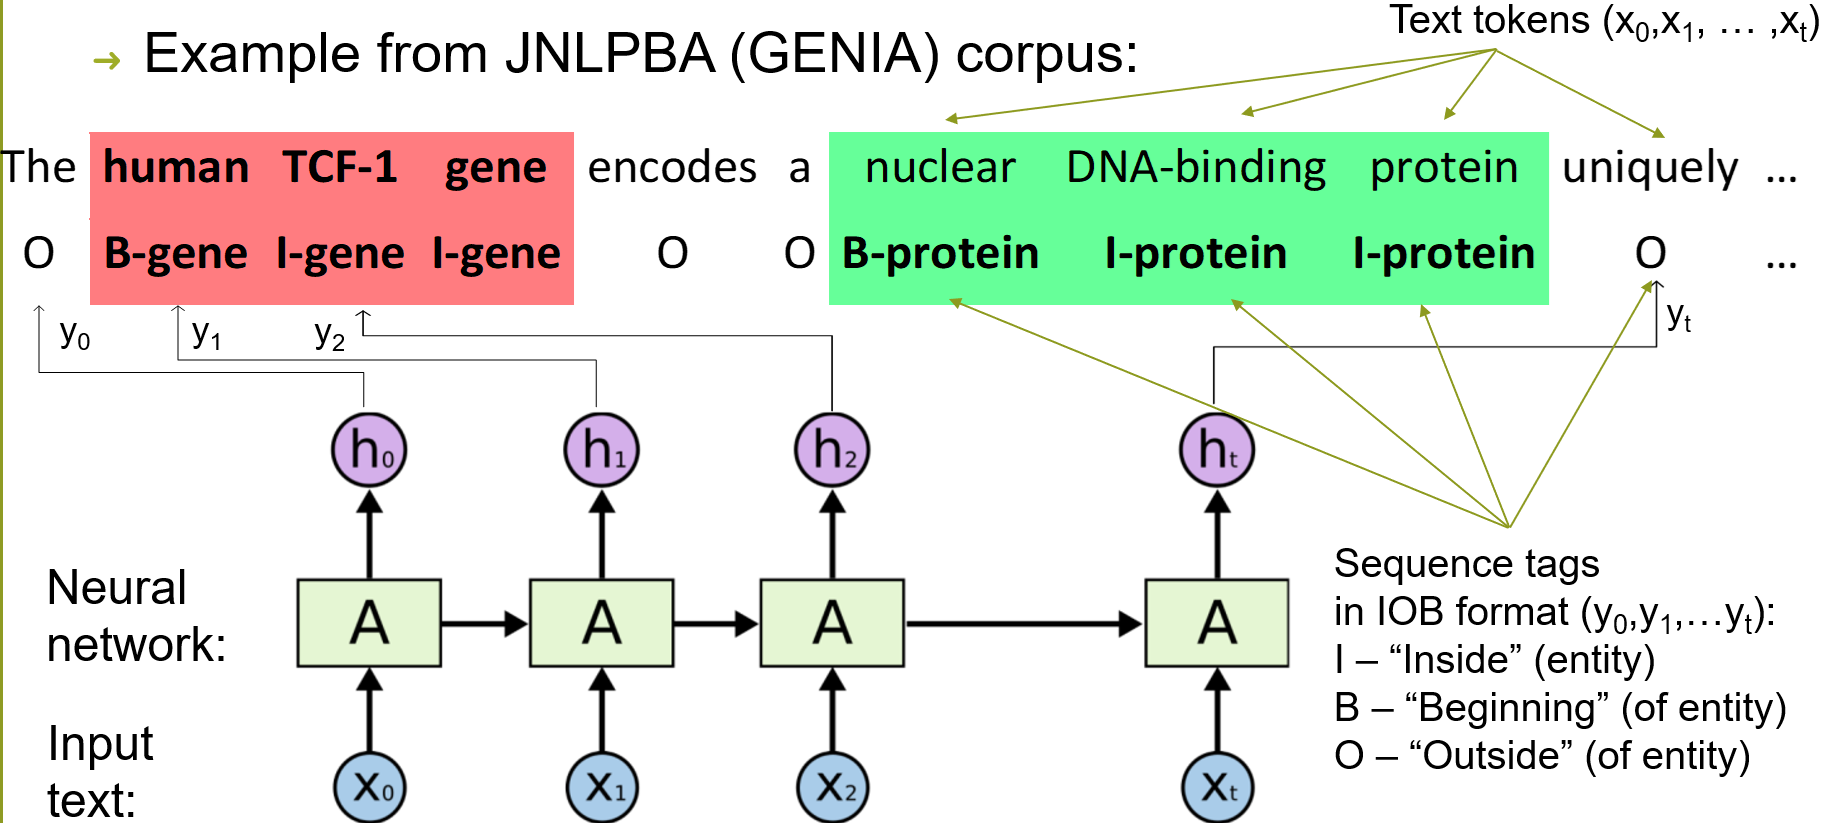

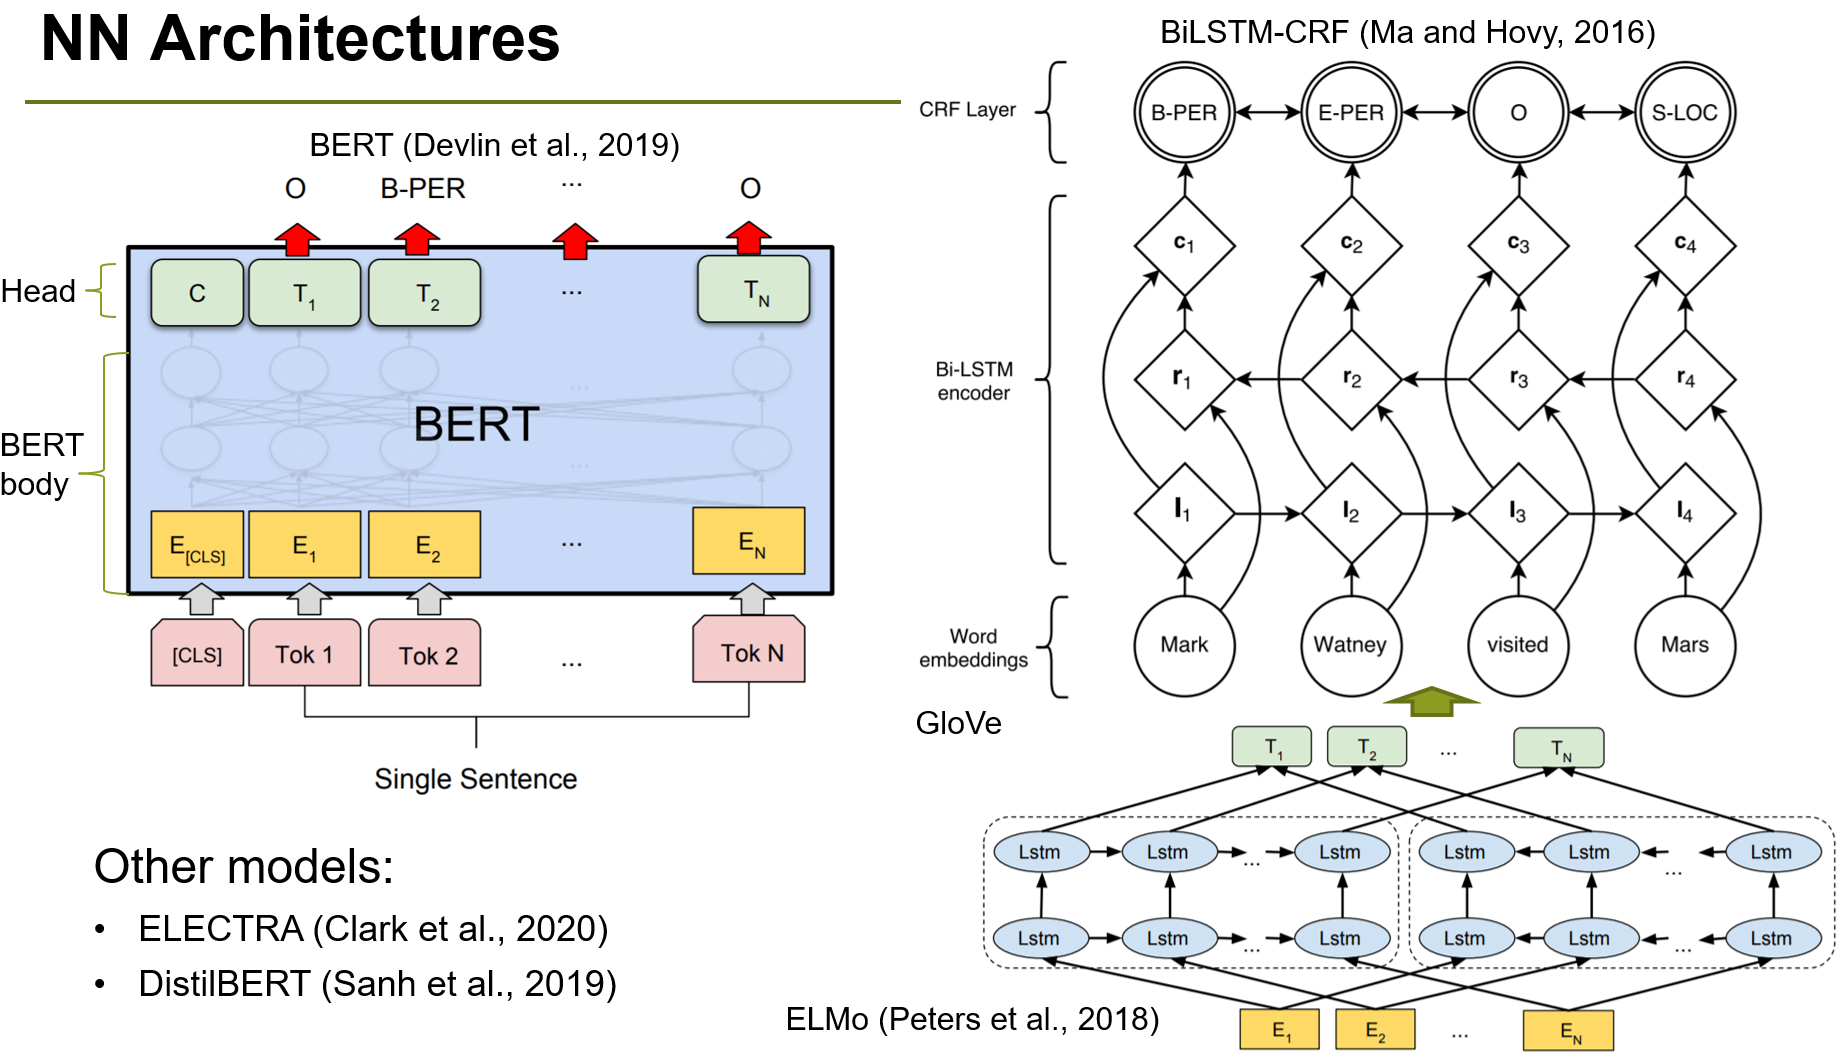



# **2. Preparation**

## 2.1 Download data

In [ ]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train    

--2020-12-06 13:13:25--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
eng.testa: Read-only file system

Cannot write to ‘eng.testa’ (Success).
--2020-12-06 13:13:25--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748096 (731K) [text/plain]
eng.testb: Read-only file system

Cannot write to ‘eng.testb’ (Success).
--2020-12-06 13:13:26--  https://raw.git

## 2.2 Initialization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

seed = 1
torch.manual_seed(seed)

import numpy as np
np.random.seed(seed)

In [ ]:
cuda_device = torch.device('cuda:0')
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

Tesla P4


## 2.3 Load corpus

In [ ]:
cd /content/drive/My Drive/Seqlab

/content/drive/.shortcut-targets-by-id/13b-Ex5HQHvV-kFf6CJHX71s-VR4wIn_J/Seqlab


In [ ]:
!ls

dataset_stage2.zip  SEqlab.ipynb	 train_clean.csv   train.tsv
dev.tsv		    test_no_answers.tsv  train_clean.xlsx


In [ ]:
import zipfile

In [ ]:
z=zipfile.ZipFile('dataset_stage2.zip', 'r')

In [ ]:
z.extractall()

PermissionError: ignored

In [ ]:
import pandas as pd

In [ ]:
!head -n 3 ./eng.train

head: cannot open './eng.train' for reading: No such file or directory


In [ ]:
!head -n 3 ./train.tsv

also	O
,	O
i	O


In [ ]:
from flair.datasets import ColumnCorpus


data_folder = './'
corpora = ColumnCorpus(data_folder, 
                      {0 : 'text', 1 : 'ner'},
                      train_file='train.tsv',
                      test_file='dev.tsv',
                      dev_file='test_no_answers.tsv')

print(corpora.obtain_statistics())

2020-12-06 17:49:46,419 Reading data from .
2020-12-06 17:49:46,420 Train: train.tsv
2020-12-06 17:49:46,420 Dev: test_no_answers.tsv
2020-12-06 17:49:46,421 Test: dev.tsv
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 2334,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 61074,
            "min": 6,
            "max": 101,
            "avg": 26.167095115681235
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 283,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 8363,
            "min": 8,
            "max": 87,
            "avg": 29.551236749116608
        }
    },
    "DEV": {
        "dataset": "DEV",
        "total_number_of_documents": 360,
        "number_of_documents_per_class": {},
        "number_of_tokens_per_tag": {},
     

In [ ]:
import nltk


def create_dataset(flair_dataset, preprocess=False):
    dataset = []
    
    for sent in flair_dataset:
        tokens = [w.text for w in sent]
        labels = [w.get_tag('ner').value for w in sent]
        
        if preprocess:
            dataset.append((list(zip(tokens, [nltk.pos_tag([tok])[0][1] for tok in tokens])), labels))
        else:
            dataset.append((tokens, labels))
        
    return dataset

# **3. Classical approach**

## 3.1 CRF

In [145]:
train_dataset = create_dataset(corpora.train, preprocess=True)
dev_dataset = create_dataset(corpora.dev, preprocess=True)
test_dataset= create_dataset(corpora.test, preprocess=True)

In [ ]:
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
import numpy as np


def word_features(sentence, i):
    # Get the current word and POS
    word = sentence[i][0]
    pos = sentence[i][1]
    
    features = { "bias": 1.0,
                 "word.lower()": word.lower(),
                 "word[-3:]": word[-3:],
                 "word[-2:]": word[-2:],
                 "word.isupper()": word.isupper(),
                 "word.istitle()": word.istitle(),
                 "word.isdigit()": word.isdigit(),
                 "pos": pos,
                 "pos[:2]": pos[:2], # Generalized POS
               }
   
    # If this is not the first word in the sentence...
    if i > 0:
        # Get the sentence's previous word and POS
        prev_word = sentence[i-1][0] if len(sentence) > 1 else ''
        prev_pos = sentence[i-1][1] if len(sentence) > 1 else ''
        # Add characteristics of the sentence's previous word and POS to the feature dictionary
        features.update({ "-1:word.lower()": prev_word.lower(),
                          "-1:word.istitle()": prev_word.istitle(),
                          "-1:word.isupper()": prev_word.isupper(),
                          "-1:pos": prev_pos,
                          "-1:pos[:2]": prev_pos[:2],
                        })
        
    # Otherwise, add 'BOS' (beginning of sentence) to the feature dictionary
    else:
        features["BOS"] = True

    # If this is not the last word in the sentence...
    if i < len(sentence)-1:
        # Get the sentence's next word and POS
        next_word = sentence[i+1][0] if len(sentence) > 1 else ''
        next_pos = sentence[i+1][1] if len(sentence) > 1 else ''
        # Add characteristics of the sentence's previous next and POS to the feature dictionary
        features.update({ "+1:word.lower()": next_word.lower(),
                          "+1:word.istitle()": next_word.istitle(),
                          "+1:word.isupper()": next_word.isupper(),
                          "+1:pos": next_pos,
                          "+1:pos[:2]": next_pos[:2],
                        })
        
    # Otherwise, add 'EOS' (end of sentence) to the feature dictionary
    else:
        features["EOS"] = True
    
    return features


def sentence_features(sentence):
    return [word_features(sentence, i) for i in range(len(sentence))]

In [ ]:
X = [sentence_features(sentence[0]) for sentence in train_dataset]
y = [sentence[1] for sentence in train_dataset]

In [ ]:
X[0]

[{'+1:pos': ',',
  '+1:pos[:2]': ',',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': ',',
  'BOS': True,
  'bias': 1.0,
  'pos': 'RB',
  'pos[:2]': 'RB',
  'word.isdigit()': False,
  'word.istitle()': False,
  'word.isupper()': False,
  'word.lower()': 'also',
  'word[-2:]': 'so',
  'word[-3:]': 'lso'},
 {'+1:pos': 'NN',
  '+1:pos[:2]': 'NN',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': 'i',
  '-1:pos': 'RB',
  '-1:pos[:2]': 'RB',
  '-1:word.istitle()': False,
  '-1:word.isupper()': False,
  '-1:word.lower()': 'also',
  'bias': 1.0,
  'pos': ',',
  'pos[:2]': ',',
  'word.isdigit()': False,
  'word.istitle()': False,
  'word.isupper()': False,
  'word.lower()': ',',
  'word[-2:]': ',',
  'word[-3:]': ','},
 {'+1:pos': 'VB',
  '+1:pos[:2]': 'VB',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:word.lower()': 'have',
  '-1:pos': ',',
  '-1:pos[:2]': ',',
  '-1:word.istitle()': False,
  '-1:word.isuppe

In [ ]:
y[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Object',
 'O',
 'O',
 'O',
 'B-Predicate',
 'O',
 'B-Predicate',
 'O',
 'O',
 'B-Aspect',
 'O',
 'O',
 'B-Object',
 'O']

In [147]:
model = sklearn_crfsuite.CRF()
model.fit(X, y)

CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
pred_data = test_dataset[1]
X_pred = [sentence_features(sentence[0]) for sentence in [pred_data]]
preds = model.predict(X_pred)

result=list(zip([e[0] for e in pred_data[0]], preds[0]))


In [ ]:
[e[1] for e in test_dataset]

[['O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'B-Aspect',
  'I-Aspect',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Object',
  'I-Object',
  'O'],
 ['O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Object',
  'I-Object',
  'O'],
 ['O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'B-Predicate',
  

In [ ]:
preds

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'O',
  'O',
  'O']]

In [ ]:
from seqeval.metrics import f1_score


X_test = [sentence_features(sentence[0]) for sentence in test_dataset]
preds = model.predict(X_test)

f1_score = f1_score([e[1] for e in test_dataset], preds)

print(f'F1 score: {f1_score}')

F1 score: 0.5485193621867881


In [148]:
from seqeval.metrics import f1_score


X_test = [sentence_features(sentence[0]) for sentence in train_dataset]
preds = model.predict(X_test)

f1_score = f1_score([e[1] for e in train_dataset], preds)

print(f'F1 score: {f1_score}')

F1 score: 0.8733081668354664


## 3.2 BiLSTM model

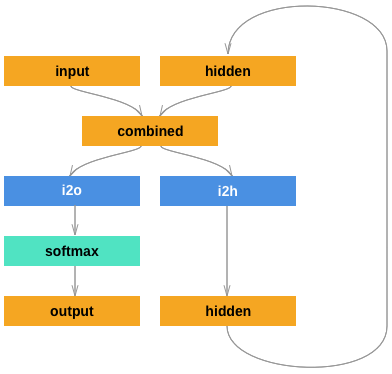



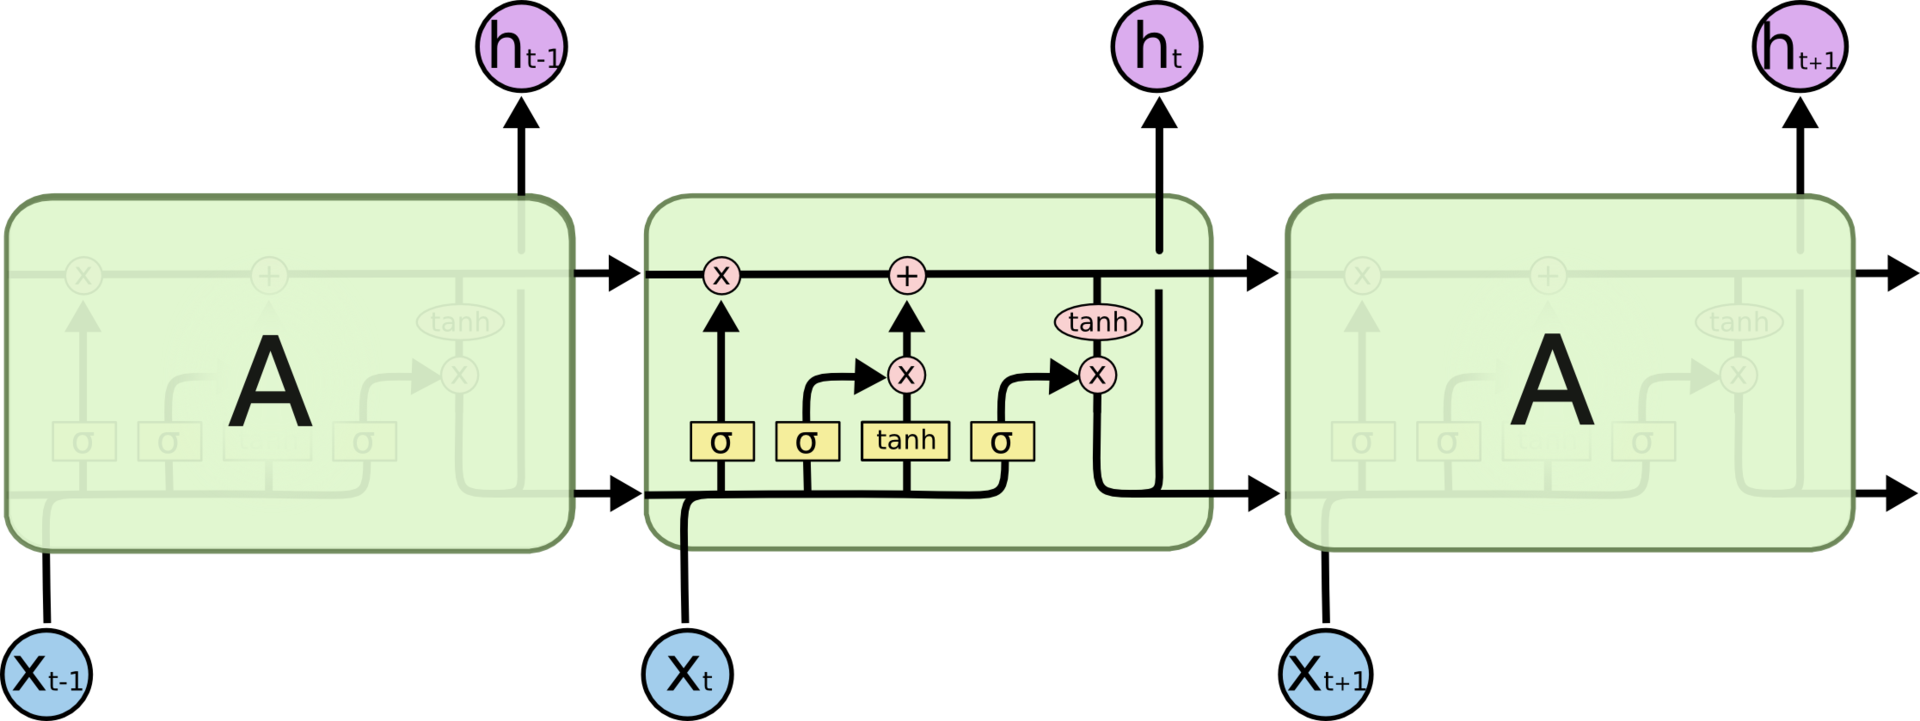

In [ ]:
train_dataset = create_dataset(corpora.train, preprocess=False)
dev_dataset = create_dataset(corpora.dev, preprocess=False)
test_dataset= create_dataset(corpora.test, preprocess=False)

In [ ]:
# Example network

lstm = nn.LSTM(input_size=3, hidden_size=3) 
inputs = [torch.randn(1, 3) for _ in range(5)]  # for a sequence of length 5


hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    out, hidden = lstm(i.view(1, 1, -1), hidden)

inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[ 0.2490, -0.0525,  0.3253]],

        [[ 0.1655, -0.0304,  0.3348]],

        [[-0.1104, -0.1085,  0.7568]],

        [[-0.0148, -0.0855,  0.4162]],

        [[ 0.0703, -0.1089,  0.2071]]], grad_fn=<StackBackward>)
(tensor([[[ 0.0703, -0.1089,  0.2071]]], grad_fn=<StackBackward>), tensor([[[ 0.2099, -0.3541,  0.9947]]], grad_fn=<StackBackward>))


In [ ]:
word_to_ix = {}
tag_to_ix = {}

word_to_ix['PAD'] = 0
tag_to_ix['PAD'] = 0

for sent, tags in train_dataset:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

print('Vocabulary to convert words to indexes:')
print(dict(list(word_to_ix.items())[:100]))

print()

print('Vocabulary to convert tags to indexes:')
print(tag_to_ix)

Vocabulary to convert words to indexes:
{'PAD': 0, 'also': 1, ',': 2, 'i': 3, 'have': 4, 'recently': 5, 'discovered': 6, 'advil': 7, 'liquigels': 8, 'work': 9, 'much': 10, 'better': 11, 'and': 12, 'faster': 13, 'for': 14, 'a': 15, 'headache': 16, 'than': 17, 'regular': 18, 'ibuprofen': 19, '.': 20, 'always': 21, 'heard': 22, 'that': 23, 'motrin': 24, 'is': 25, 'fevers': 26, 'works': 27, 'body': 28, 'aches': 29, 'pains': 30, 'when': 31, 'was': 32, 'figure': 33, 'skater': 34, 'injuried': 35, 'my': 36, 'ankles': 37, 'all': 38, 'the': 39, 'time': 40, 'quickest': 41, 'way': 42, 'back': 43, 'on': 44, 'your': 45, 'feet': 46, 'doses': 47, 'of': 48, '(': 49, 'acting': 50, 'you': 51, 'can': 52, 'take': 53, 'it': 54, 'more': 55, 'often': 56, ')': 57, 'ice': 58, 'keeping': 59, 'above': 60, 'hip': 61, 'in': 62, 'halloween': 63, 'even': 64, 'thanksgiving': 65, 'absolute': 66, 'favorite': 67, 'holiday': 68, 'because': 69, 'divides': 70, 'us': 71, 'into': 72, 'separate': 73, 'households': 74, 'while':

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 padding_index=None,
                 max_length=128):
        super().__init__()
        
        self.padding_index = padding_index  # if None, don't use masking
        
        # embeddings
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        # encoder layers (implemented below)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        
        # dropout is applied after summing up token and positional embeddings
        self.dropout = nn.Dropout(dropout)
        
        # scale parameter
        self.scale = torch.nn.Parameter(torch.sqrt(torch.tensor(hid_dim, dtype=torch.float32)), requires_grad=False)
        
        # custom weight initialization
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)
        
    def forward(self, x):
        """
        x (batch of token indices): torch.long tensor of shape [bs, seq_len]
        
        returns (encoded sequence): torch.float32 tensor of shape [bs, seq_len, output_dim]
        """
        device = x.device
        bs, seq_len = x.shape[:2]
        
        # compute non-padding mask (use self.padding_index)
        mask = None
        if self.padding_index is not None:
            mask = (x != self.padding_index).unsqueeze(1).unsqueeze(2)
        
        # get token embeddings and scale with self.scale parameter
        tok_emb = self.tok_embedding(x) * self.scale
        #print(x.shape)
        
        # generate input [0, 1, ..., seq_len - 1] for positional embedder [bs, seq_len]
        inp = (torch.arange(0, x.shape[1])).repeat(x.shape[0], 1)
        #print(inp.shape)
        # get pos embeddings
        pos_emb = self.pos_embedding(inp.to(device))
        #print(tok_emb.shape)
        #print(pos_emb.shape)
        # sum up token and positional embeddings
        x = tok_emb + pos_emb
        
        # apply dropout
        x = self.dropout(x)
        
        # apply encoder layers one by one; input shape is [bs, seq_len, hid dim]
        for l in self.layers:
          x = l(x, mask)

        return x

class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout):
        super().__init__()
        
        # self-attention layer normalization
        self.attention_layer_norm = nn.LayerNorm(hid_dim)
        
        # positionwise feedforward layer normalization
        self.pf_layer_norm = nn.LayerNorm(hid_dim)
        
        # attention layer (implemented below)
        self.attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        
        # positionwise feedforward layer (implemented below)
        self.pf = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        # dropout is applied to the outputs of the attention and positionwise feedforward layers
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        x (sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        mask (mask of valid elements): torch.bool tensor of shape [bs, seq_len]
        
        returns (processed sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        """
        ### block 1
        # calculate self-attention + dropout
        ## your code here
        att = self.dropout(self.attention(x, x, x, mask))
        
        # residual (attention) + attention layer norm
        ## your code here
        x = self.attention_layer_norm(x + att) 
        
        ### block 2
        # calculate positionwise feedforward + dropout
        ff = self.dropout(self.pf(x))

        
        # residual (positionwise feedforward) + positionwise feedforward layer norm
        x = self.pf_layer_norm(x + ff)

        return x

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout):
        super().__init__()
        
        assert hid_dim % n_heads == 0, "hid_dim must be divisible by n_heads"
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        # query, key and value linear networks
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        # output linear networks
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        # dropout is applied to attention
        self.dropout = nn.Dropout(dropout)
        
        # scale parameter
        self.scale = torch.nn.Parameter(torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32)), requires_grad=False)

    def prep(self, qkv):
        #print(qkv.shape)
        return torch.transpose((qkv.view(qkv.shape[0], -1, self.n_heads, self.head_dim)), 1, 2)
    
    def forward(self, query, key, value, mask=None):
        """
        query/key/value (batch of queries/keys/values): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        mask (mask of valid elements): torch.bool tensor of shape [bs, seq_len]
        
        returns (multi-head attention): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        """
        
        bs = query.shape[0]
        
        # calculate Q, K, V using corresponding linear networks
        q, k, v = self.fc_q(query), self.fc_k(key), self.fc_v(value)  # shape is [bs, seq_len, hid_dim]
        #print(q)
        # prepare Q, K, V for .matmul() or `@` operator
        # shape is [bs, n_heads, seq_len, head_dim]
        q = self.prep(q)
        k = self.prep(k)
        v = self.prep(v)
        # compute energy using .matmul() or `@` operator (don't forget to scale!)
        # shape is [bs, n_heads, seq_len, seq_len]
        energy = torch.matmul(q, torch.transpose(k,2,3)) / self.scale
        
        # apply mask – 1 in mask is a valid element, 0 - not (use .masked_fill())
        if mask is not None:
            energy = energy.masked_fill(mask == 0, 1e-12)
        
        # apply softmax along the last dim of energy and get the attention weights
        # shape is [bs, n_heads, seq_len, seq_len]
        attention = torch.softmax(energy, -1)
        
        # weight values with calculated attention + dropout (use .matmul() or `@` operator)
        # shape is [bs, n_heads, seq_len, head_dim]
        x = torch.matmul(self.dropout(attention), v)
        
        # squash 1 and 4 dims back
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(bs, -1, self.hid_dim)  # shape is [bs, seq_len, hid_dim]
        
        # apply output linear layer
        x = self.fc_o(x)
        
        return x
    
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        # linear layers
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        # dropout is applied after the first layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x (sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        
        returns (processed sequence of vectors): torch.float32 tensor of shape [bs, seq_len, hid_dim]
        """
        # apply linear layers + dropout
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        
        return x

class TransformerPOSTagger(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hid_dim=64, 
                 n_layers=8, 
                 n_heads=8, 
                 pf_dim=64,
                 dropout=0.1, 
                 padding_index=None,
                 max_length=128):
        super().__init__()
        
        # transformer encoder
        self.encoder = Encoder(
            input_dim,
            hid_dim=hid_dim, 
            n_layers=n_layers, 
            n_heads=n_heads, 
            pf_dim=pf_dim,
            dropout=dropout, 
            padding_index=padding_index,
            max_length=max_length
        )
        
        # linear layer to predict (classify) pos-tags
        self.postag_predictor = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x):
        # apply encoder
        x = self.encoder(x)
        
        # predict postags
        x = self.postag_predictor(x)        
        return x

In [ ]:
model = TransformerPOSTagger()

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class BasicLstmTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, 
                 tagset_size, dropout_rate=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentences, lengths):
        embeds = self.word_embeddings(sentences)

        packed_embeds = pack_padded_sequence(embeds.transpose(0, 1), lengths, enforce_sorted=False)
        packed_lstm_out, _ = self.lstm(packed_embeds)
        lstm_out, _ = pad_packed_sequence(packed_lstm_out)

        tag_space = self.hidden2tag(self.dropout(lstm_out.transpose(0, 1)))
        tag_scores = F.log_softmax(tag_space, dim=-1)
        return tag_scores

In [ ]:
class ConvPOSTagger(nn.Module):
    def __init__(self, hid_dim, output_dim, n_tokens):
        """ 
        x -> Embedding -> Conv -> ReLU -> Conv -> ReLU -> Conv -> ReLU -> Conv
        
        n_tokens: # of unique tokens
        hid_dim: # of channels of intermediate layers (with expansion)
        output_dim: # of unique POS-tags)
        """
        super().__init__()

        self.emb = nn.Embedding(n_tokens, hid_dim).to(device)
        self.layers = nn.Sequential(
            nn.Conv1d(hid_dim, 2 * hid_dim, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(2 * hid_dim, 4 * hid_dim, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(4 * hid_dim, 8 * hid_dim, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(8 * hid_dim, output_dim, kernel_size=1)  # note: no activation here
        )

    def forward(self, x):
        """
        x: torch.long tensor of shape [batch_size, sequence_length]
        returns: torch.float32 tensor of shape [batch_size, sequence_length, output_dim]
        """
        x = self.emb(x)  # get embeddings
        
        # transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        x = torch.transpose(x, 1, 2)
        
        # encode
        x = self.layers(x)
        
        # transpose back to [batch, time, units]
        x = torch.transpose(x, 1, 2)
        
        return x

In [ ]:
model = TransformerPOSTagger(input_dim=300,output_dim=len(tag_to_ix)).cuda()

In [ ]:
model = BasicLstmTagger(embedding_dim=300, 
                        hidden_dim=200, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix)).cuda()

In [ ]:
def prepare_tokens(batch_tokens, word_to_ix):
    batch_token_ids = [[word_to_ix.get(tok, 0) for tok in inst] for inst in batch_tokens]
    batch_max_len = max([len(s) for s in batch_token_ids])
    
    batch_token_ids_padded = word_to_ix['PAD']*np.ones((len(batch_token_ids), batch_max_len))
    lengths = []
    for i in range(len(batch_token_ids)):
        cur_len = len(batch_token_ids[i])
        batch_token_ids_padded[i][:cur_len] = batch_token_ids[i]
        lengths.append(cur_len)

    #since all data are indices, we convert them to torch LongTensors
    return torch.LongTensor(batch_token_ids_padded), lengths


def prepare_tags(batch_tags, tag_to_ix):
    batch_tag_ids = [[tag_to_ix[tag] for tag in inst] for inst in batch_tags]
    batch_max_len = max([len(s) for s in batch_tag_ids])

    batch_tag_ids_padded = tag_to_ix['PAD']*np.ones((len(batch_tag_ids), batch_max_len))
    for i in range(len(batch_tag_ids)):
        cur_len = len(batch_tag_ids[i])
        batch_tag_ids_padded[i][:cur_len] = batch_tag_ids[i]

    #since all data are indices, we convert them to torch LongTensors
    return torch.LongTensor(batch_tag_ids_padded)


def prepare_instance_for_training(batch_instances, word_to_ix, tag_to_ix):
    tokens, lengths = prepare_tokens([inst[0] for inst in batch_instances], word_to_ix)
    tags = prepare_tags([inst[1] for inst in batch_instances], tag_to_ix)

    return tokens, lengths, tags

In [ ]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


N_EPOCHS = 30
LEARNING_RATE = 0.1
BATCH_SIZE= 8

loss_function = nn.NLLLoss(ignore_index=tag_to_ix['PAD'])
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

f_preprocess = lambda batch: prepare_instance_for_training(batch, word_to_ix, tag_to_ix)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=f_preprocess)

try:
    model.train()
    for epoch in range(N_EPOCHS):
        print(f'Epoch #{epoch}')
        loss_val = 0
        for sentences, lengths, targets in tqdm(train_dataloader):
            # Move data to the GPU.
            sentences = sentences.cuda()
            targets = targets.cuda()
            print(sentences.shape)
            print(targets.shape)

            # Pytorch accumulates gradients. We clear them out before each instance.
            model.zero_grad()

            # Run our forward pass.
            tag_scores = model(sentences)#, lengths)

            # Compute the loss, gradients, and update the parameters. 
            loss = loss_function(tag_scores.reshape(-1, tag_scores.shape[-1]), targets.reshape(-1))
            loss_val += loss.item()
            loss.backward()
            optimizer.step()
        print(loss_val/len(train_dataloader))
except KeyboardInterrupt:
    pass

Epoch #0


RuntimeError: ignored

In [ ]:
# Evaluation

pred_dataset = [inst[0] for inst in test_dataset]

f_preprocess = lambda batch: prepare_tokens(batch, word_to_ix)
pred_dataloader = DataLoader(pred_dataset, 
                             batch_size=100, 
                             num_workers=1,
                             collate_fn=f_preprocess)

model.eval()

all_preds = []
all_probas = []
with torch.no_grad():
    for sentences, lengths in pred_dataloader:
        sentences = sentences.cuda()

        tag_scores = model(sentences, lengths)
        probas, pred_tags = tag_scores.max(dim=-1)
        probas = torch.exp(probas)
        
        pred_tags = pred_tags.cpu().tolist()
        probas = probas.cpu().tolist()
        all_preds += pred_tags
        all_probas += probas

In [ ]:
# Restoring tag strings

ix_to_tag = {v: k for k, v in tag_to_ix.items()}

pred_tags = []
pred_probas = []
for pred_sent, preds, probas in zip(pred_dataset, all_preds, all_probas):
    pred_tags.append([ix_to_tag[tag_idx] for tag_idx in preds[:len(pred_sent)]])
    pred_probas.append(probas[:len(pred_sent)])

idx = 10
list(zip(pred_dataset[idx], pred_tags[idx], pred_probas[idx]))

[('but', 'O', 0.9999998807907104),
 ('that', 'O', 0.9999998807907104),
 ('aside', 'O', 0.9995412230491638),
 (',', 'O', 1.0),
 ('windows', 'O', 0.9992483854293823),
 ('10', 'O', 0.9999494552612305),
 ('is', 'O', 1.0),
 ('still', 'O', 0.9999805092811584),
 ('easier', 'B-Predicate', 0.9971004128456116),
 ('to', 'O', 0.9948835372924805),
 ('navigate', 'B-Aspect', 0.9940919280052185),
 ('than', 'O', 0.9999271035194397),
 ('mac', 'B-Aspect', 0.7462382316589355),
 ('os', 'B-Aspect', 0.5141594409942627),
 ('x', 'I-Aspect', 0.8499688506126404),
 ('and', 'O', 0.9898800253868103),
 ('windows', 'B-Object', 0.9707750082015991),
 ('8', 'O', 0.6693305969238281),
 (',', 'O', 0.9999993443489075),
 ('has', 'O', 0.999842643737793),
 ('better', 'B-Predicate', 0.9983054399490356),
 ('access', 'B-Aspect', 0.9929148554801941),
 ('to', 'I-Aspect', 0.5891334414482117),
 ('files', 'I-Aspect', 0.724412202835083),
 ('than', 'O', 1.0),
 ('in', 'O', 0.9999998807907104),
 ('android', 'O', 0.9977757334709167),
 (','

In [ ]:
from seqeval.metrics import f1_score

f1_score(pred_tags, [inst[1] for inst in test_dataset])

0.5013850415512465

# **4. AllenNLP**

In [ ]:
#!pip install AllenNLP

In [ ]:
from torch.utils.data import DataLoader
from allennlp.data import allennlp_collate
from allennlp.training.util import evaluate
from allennlp.predictors import SentenceTaggerPredictor
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder

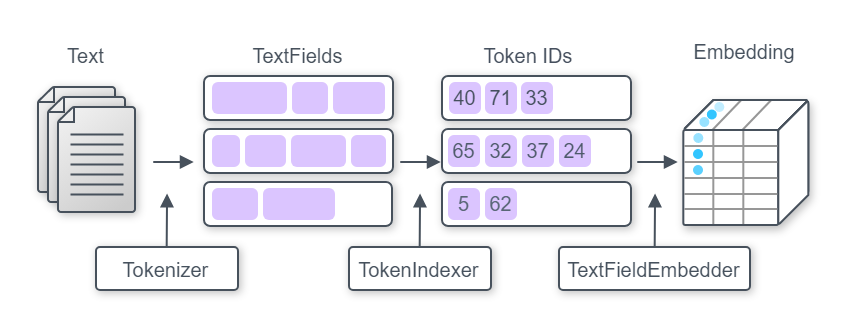

## 4.1 LSTM model

In [ ]:
!ls

dataset_stage2.zip  SEqlab.ipynb	 train_clean.csv   train.tsv
dev.tsv		    test_no_answers.tsv  train_clean.xlsx


In [ ]:
pd.read_csv('train.tsv', sep='\t')

NameError: ignored

In [80]:
from typing import Dict, List, Sequence, Iterable
import itertools
import logging

from overrides import overrides

from allennlp.common.checks import ConfigurationError
from allennlp.common.file_utils import cached_path
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.dataset_readers.dataset_utils import to_bioul
from allennlp.data.fields import TextField, SequenceLabelField, Field, MetadataField
from allennlp.data.instance import Instance
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token

logger = logging.getLogger(__name__)

def _is_divider(line: str) -> bool:
    empty_line = line.strip() == ""
    if empty_line:
        return True
    else:
        first_token = line.split()[0]
        if first_token == "-DOCSTART-":
            return True
        else:
            return False


class SeqDatasetReader(DatasetReader):
    """
    Reads instances from a pretokenised file where each line is in the following format:
    ```
    WORD POS-TAG CHUNK-TAG NER-TAG
    ```
    with a blank line indicating the end of each sentence
    and `-DOCSTART- -X- -X- O` indicating the end of each article,
    and converts it into a `Dataset` suitable for sequence tagging.
    Each `Instance` contains the words in the `"tokens"` `TextField`.
    The values corresponding to the `tag_label`
    values will get loaded into the `"tags"` `SequenceLabelField`.
    And if you specify any `feature_labels` (you probably shouldn't),
    the corresponding values will get loaded into their own `SequenceLabelField` s.
    This dataset reader ignores the "article" divisions and simply treats
    each sentence as an independent `Instance`. (Technically the reader splits sentences
    on any combination of blank lines and "DOCSTART" tags; in particular, it does the right
    thing on well formed inputs.)
    Registered as a `DatasetReader` with name "conll2003".
    # Parameters
    token_indexers : `Dict[str, TokenIndexer]`, optional (default=`{"tokens": SingleIdTokenIndexer()}`)
        We use this to define the input representation for the text.  See :class:`TokenIndexer`.
    tag_label : `str`, optional (default=`ner`)
        Specify `ner`, `pos`, or `chunk` to have that tag loaded into the instance field `tag`.
    feature_labels : `Sequence[str]`, optional (default=`()`)
        These labels will be loaded as features into the corresponding instance fields:
        `pos` -> `pos_tags`, `chunk` -> `chunk_tags`, `ner` -> `ner_tags`
        Each will have its own namespace : `pos_tags`, `chunk_tags`, `ner_tags`.
        If you want to use one of the tags as a `feature` in your model, it should be
        specified here.
    coding_scheme : `str`, optional (default=`IOB1`)
        Specifies the coding scheme for `ner_labels` and `chunk_labels`.
        Valid options are `IOB1` and `BIOUL`.  The `IOB1` default maintains
        the original IOB1 scheme in the CoNLL 2003 NER data.
        In the IOB1 scheme, I is a token inside a span, O is a token outside
        a span and B is the beginning of span immediately following another
        span of the same type.
    label_namespace : `str`, optional (default=`labels`)
        Specifies the namespace for the chosen `tag_label`.
    """

    _VALID_LABELS = {"ner"}

    def __init__(
        self,
        token_indexers: Dict[str, TokenIndexer] = None,
        tag_label: str = "ner",
        feature_labels: Sequence[str] = (),
        coding_scheme: str = "IOB1",
        label_namespace: str = "labels",
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)
        self._token_indexers = token_indexers or {"tokens": SingleIdTokenIndexer()}
        if tag_label is not None and tag_label not in self._VALID_LABELS:
            raise ConfigurationError("unknown tag label type: {}".format(tag_label))
        for label in feature_labels:
            if label not in self._VALID_LABELS:
                raise ConfigurationError("unknown feature label type: {}".format(label))
        if coding_scheme not in ("IOB1", "BIOUL"):
            raise ConfigurationError("unknown coding_scheme: {}".format(coding_scheme))

        self.tag_label = tag_label
        self.feature_labels = set(feature_labels)
        self.coding_scheme = coding_scheme
        self.label_namespace = label_namespace
        self._original_coding_scheme = "IOB1"

    @overrides
    def _read(self, file_path: str) -> Iterable[Instance]:
        # if `file_path` is a URL, redirect to the cache
        file_path = cached_path(file_path)

        with open(file_path, "r") as data_file:
            logger.info("Reading instances from lines in file at: %s", file_path)

            # Group into alternative divider / sentence chunks.
            for is_divider, lines in itertools.groupby(data_file, _is_divider):
                # Ignore the divider chunks, so that `lines` corresponds to the words
                # of a single sentence.
                if not is_divider:
                    fields = [line.strip().split() for line in lines]
                    # unzipping trick returns tuples, but our Fields need lists
                    fields = [list(field) for field in zip(*fields)]
                    tokens_, ner_tags = fields
                    # TextField requires `Token` objects
                    tokens = [Token(token) for token in tokens_]

                    yield self.text_to_instance(tokens, ner_tags)

    def text_to_instance(  # type: ignore
        self,
        tokens: List[Token],
        ner_tags: List[str] = None,
    ) -> Instance:
        """
        We take `pre-tokenized` input here, because we don't have a tokenizer in this class.
        """

        sequence = TextField(tokens, self._token_indexers)
        instance_fields: Dict[str, Field] = {"tokens": sequence}
        instance_fields["metadata"] = MetadataField({"words": [x.text for x in tokens]})

        # Recode the labels if necessary.
        if self.coding_scheme == "BIOUL":
            coded_ner = (
                to_bioul(ner_tags, encoding=self._original_coding_scheme)
                if ner_tags is not None
                else None
            )
        else:
            # the default IOB1
            coded_ner = ner_tags

        if "ner" in self.feature_labels:
            if coded_ner is None:
                raise ConfigurationError(
                    "Dataset reader was specified to use NER tags as "
                    " features. Pass them to text_to_instance."
                )
            instance_fields["ner_tags"] = SequenceLabelField(coded_ner, sequence, "ner_tags")

        # Add "tag label" to instance
        if self.tag_label == "ner" and coded_ner is not None:
            instance_fields["tags"] = SequenceLabelField(coded_ner, sequence, self.label_namespace)
        return Instance(instance_fields)

In [81]:
from allennlp.data.token_indexers import SingleIdTokenIndexer


indexer = SingleIdTokenIndexer()
print(indexer)

In [82]:
from allennlp.data.dataset_readers import SequenceTaggingDatasetReader
from allennlp.data.token_indexers import SingleIdTokenIndexer


reader = SeqDatasetReader()

#indexer = SingleIdTokenIndexer()
#reader = Conll2003DatasetReader(token_indexers={'tokens': indexer})
#train_dataset = reader.read('train.tsv')
#dev_dataset = reader.read('dev.tsv')
#test_dataset = reader.read('test_no_answers.tsv')
#train_dataset = create_dataset(corpora.train, preprocess=False)
#dev_dataset = create_dataset(corpora.dev, preprocess=False)
#test_dataset= create_dataset(corpora.test, preprocess=False)

train_dataset = reader.read('train.tsv')
dev_dataset = reader.read('dev.tsv')
#test_dataset = reader.read('test_no_answers.tsv')






reading instances: 0it [00:00, ?it/s]




reading instances: 2334it [00:00, 12815.74it/s]





reading instances: 283it [00:00, 9808.85it/s]


In [83]:
print(train_dataset[0])

Instance with fields:
 	 tokens: TextField of length 20 with text: 
 		[also, ,, i, have, recently, discovered, advil, liquigels, work, much, better, and, faster, for, a,
		headache, than, regular, ibuprofen, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 metadata: MetadataField (print field.metadata to see specific information). 
 	 tags: SequenceLabelField of length 20 with labels:
 		['O', 'O', 'O', 'O', 'O', 'O', 'B-Object', 'O', 'O', 'O', 'B-Predicate', 'O', 'B-Predicate', 'O',
		'O', 'B-Aspect', 'O', 'O', 'B-Object', 'O']
 		in namespace: 'labels'. 



In [84]:
from allennlp.data.vocabulary import Vocabulary

vocab = Vocabulary.from_instances(train_dataset.instances)
train_dataset.index_with(vocab)
dev_dataset.index_with(vocab)
#test_dataset.index_with(vocab)






building vocab: 100%|##########| 2334/2334 [00:00<00:00, 43839.17it/s]


In [85]:
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.seq2seq_encoders.pytorch_seq2seq_wrapper import LstmSeq2SeqEncoder
from allennlp.modules.token_embedders import Embedding


embedder = Embedding(embedding_dim=300, vocab=vocab)
text_field_embedder = BasicTextFieldEmbedder({'tokens': embedder})
encoder = LstmSeq2SeqEncoder(input_size=embedder.get_output_dim(), hidden_size=200, bidirectional=True)

In [86]:
from allennlp.models import SimpleTagger


model = SimpleTagger(text_field_embedder=text_field_embedder, 
                     vocab=vocab, 
                     encoder=encoder,
                     calculate_span_f1=True,
                     label_encoding='IOB1').cuda()

In [87]:
model

SimpleTagger(
  (text_field_embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (encoder): LstmSeq2SeqEncoder(
    (_module): LSTM(300, 200, batch_first=True, bidirectional=True)
  )
  (tag_projection_layer): TimeDistributed(
    (_module): Linear(in_features=400, out_features=7, bias=True)
  )
)

In [88]:
import torch.optim as optim
from datetime import datetime

from allennlp.training.learning_rate_schedulers import ReduceOnPlateauLearningRateScheduler
from allennlp.data import allennlp_collate
from allennlp.training import GradientDescentTrainer

date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')

optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=8, 
                               collate_fn=allennlp_collate, shuffle=True)
dev_data_loader = DataLoader(dataset=dev_dataset, batch_size=100, collate_fn=allennlp_collate)
lr_scheduler = ReduceOnPlateauLearningRateScheduler(optimizer, patience=1, factor=0.5)

trainer = GradientDescentTrainer(
    model=model,
    #serialization_dir=f'./workdir/{date_str}/{time_str}',
    data_loader=train_data_loader,
    validation_data_loader=dev_data_loader,
    num_epochs=10,
    optimizer=optimizer,
    cuda_device=cuda_device,
    learning_rate_scheduler=lr_scheduler,
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled





  0%|          | 0/292 [00:00<?, ?it/s]




accuracy: 0.7253, accuracy3: 0.8492, precision-overall: 0.0995, recall-overall: 0.0755, f1-measure-overall: 0.0859, batch_loss: 1.4725, loss: 1.6982 ||:   3%|2         | 8/292 [00:00<00:03, 74.06it/s]




accuracy: 0.7526, accuracy3: 0.8944, precision-overall: 0.0995, recall-overall: 0.0351, f1-measure-overall: 0.0519, batch_loss: 1.1624, loss: 1.5157 ||:   5%|5         | 16/292 [00:00<00:03, 73.76it/s]




accuracy: 0.7627, accuracy3: 0.9104, precision-overall: 0.0995, recall-overall: 0.0228, f1-measure-overall: 0.0370, batch_loss: 1.0803, loss: 1.3802 ||:   8%|8         | 24/292 [00:00<00:03, 73.64it/s]




accuracy: 0.7726, accuracy3: 0.9194, precision-overall: 0.0995, recall-overall: 0.0168, f1-measure-overall: 0.0288, batch_loss: 0.9428, loss: 1.2773 ||:  11%|#         | 32/292 [00:00<00:03, 73.50it/s]




accuracy: 0.7811, accura

In [ ]:
[e[1] for e in test_dataset]

[['O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'B-Aspect',
  'I-Aspect',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Object',
  'I-Object',
  'O'],
 ['O',
  'O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Object',
  'I-Object',
  'O'],
 ['O',
  'O',
  'B-Object',
  'I-Object',
  'O',
  'O',
  'B-Predicate',
  

In [ ]:
from allennlp.training.util import evaluate

test_dataloader = DataLoader(test_dataset, batch_size=100, collate_fn=allennlp_collate)
evaluate(model, test_dataloader, cuda_device=0)


  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: ignored

In [89]:
from allennlp.predictors import SentenceTaggerPredictor
import numpy as np
from seqeval.metrics import f1_score


predictor = SentenceTaggerPredictor(model, reader)
preds = predictor.predict('also, i, have, recently, discovered, advil, liquigels, work, much, better, and, faster, for, a, headache, than, regular, ibuprofen,')
list(zip(preds['words'], preds['tags']))

[('also', 'O'),
 (',', 'O'),
 ('i', 'O'),
 (',', 'O'),
 ('have', 'O'),
 (',', 'O'),
 ('recently', 'O'),
 (',', 'O'),
 ('discovered', 'O'),
 (',', 'O'),
 ('advil', 'O'),
 (',', 'O'),
 ('liquigels', 'O'),
 (',', 'O'),
 ('work', 'O'),
 (',', 'O'),
 ('much', 'O'),
 (',', 'O'),
 ('better', 'O'),
 (',', 'O'),
 ('and', 'O'),
 (',', 'O'),
 ('faster', 'O'),
 (',', 'O'),
 ('for', 'O'),
 (',', 'O'),
 ('a', 'O'),
 (',', 'O'),
 ('headache', 'O'),
 (',', 'O'),
 ('than', 'O'),
 (',', 'O'),
 ('regular', 'O'),
 (',', 'O'),
 ('ibuprofen', 'O'),
 (',', 'O')]

## 4.2 Pre-trained embeddings (GloVe)

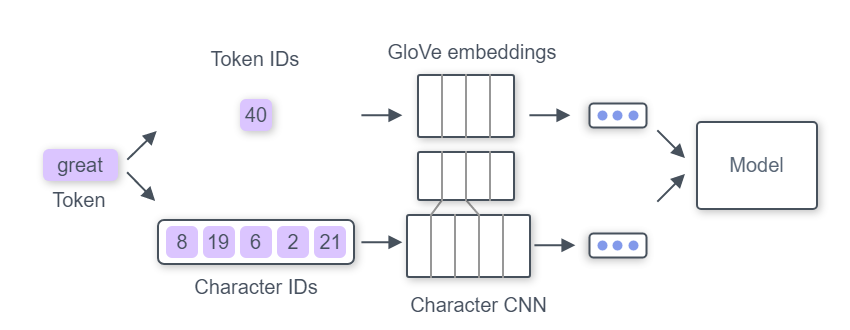

In [90]:
embedding_dim = 300
glove_file = f'https://allennlp.s3.amazonaws.com/datasets/glove/glove.6B.{embedding_dim}d.txt.gz'

embedder = Embedding(embedding_dim=embedding_dim, vocab=vocab, 
                     pretrained_file=glove_file, trainable=False)
text_field_embedder = BasicTextFieldEmbedder({'tokens': embedder})
encoder = LstmSeq2SeqEncoder(input_size=embedder.get_output_dim(), hidden_size=200, bidirectional=True)

400000it [00:09, 42845.50it/s]


In [96]:
from allennlp.models import SimpleTagger


model = SimpleTagger(text_field_embedder=text_field_embedder, 
                     vocab=vocab, 
                     encoder=encoder,
                     calculate_span_f1=True,
                     label_encoding='IOB1').cuda(device=cuda_device)

In [97]:
import torch.optim as optim

from allennlp.training.learning_rate_schedulers import ReduceOnPlateauLearningRateScheduler
from allennlp.training import GradientDescentTrainer


#optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=8, 
                               collate_fn=allennlp_collate, shuffle=True)
dev_data_loader = DataLoader(dataset=dev_dataset, batch_size=100, collate_fn=allennlp_collate)
lr_scheduler = ReduceOnPlateauLearningRateScheduler(optimizer, patience=1, factor=0.5)

date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')

trainer = GradientDescentTrainer(
    model=model,
    #serialization_dir=f'./workdir/{date_str}/{time_str}',
    data_loader=train_data_loader,
    validation_data_loader=dev_data_loader,
    num_epochs=30,
    optimizer=optimizer,
    cuda_device=cuda_device,
    learning_rate_scheduler=lr_scheduler,
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
accuracy: 0.9234, accuracy3: 0.9861, precision-overall: 0.8447, recall-overall: 0.7474, f1-measure-overall: 0.7931, batch_loss: 0.1159, loss: 0.2719 ||: 100%|##########| 292/292 [00:04<00:00, 65.81it/s]
accuracy: 0.8410, accuracy3: 0.9709, precision-overall: 0.5290, recall-overall: 0.4424, f1-measure-overall: 0.4818, batch_loss: 0.6174, loss: 0.5908 ||: 100%|##########| 3/3 [00:00<00:00, 26.56it/s]
accuracy: 0.9488, accuracy3: 0.9973, precision-overall: 0.8539, recall-overall: 0.8591, f1-measure-overall: 0.8565, batch_loss: 0.2911, loss: 0.1557 ||: 100%|##########| 292/292 [00:03<00:00, 73.93it/s]
accuracy: 0.8459, accuracy3: 0.9665, precision-overall: 0.5593, recall-overall: 0.4438, f1-measure-overall: 0.4949, batch_loss: 0.6985, loss: 0.6600 ||: 100%|##########| 3/3 [00:00<00:00, 29.31it/s]
accuracy: 0.9556, accuracy3: 0.9980, precision-overall: 0.8649, recall-overall: 0.8822, f1-m

In [77]:
test_dataloader = DataLoader(test_dataset, batch_size=100, collate_fn=allennlp_collate)
evaluate(model, test_dataloader, cuda_device=0)






  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: ignored

In [100]:
test_dataset= create_dataset(corpora.dev, preprocess=True)

In [113]:
for i in range(len(test_dataset)):
  strr = ''
  for item in test_dataset[i][0]:
    strr = strr + item[0] + ' '
  print(strr)

plus , android is developing a way faster than ios so it has chances to become a laptop replacement earlier than ios . 
went to android earlier this year after being convinced its better then ios apple . 
the version we showed here is ios only , because the ios code supported ibeacons earlier than android , but we are almost finished with an android one as well . 
he ' ll quickly realize why android is a better os - and even simpler to use than ios for most daily tasks . 
and when it comes to a os being simple to use , bada is simpler to use than android ( and lots faster too ), but bada still has more functions than ios or wp7 . 
that ' s why it ' s so ridiculous to say that ios is simpler to use than android . 
in my view , ios is still simpler to use than android , and made even simpler in ios 7 . 
as much as i hate to say it , android is not inferior to ios any longer , and they have reached parity . 
ios is still good , but no longer is better than android . 
this matters very lit

In [111]:
print(strr)

plus,androidisdevelopingawayfasterthaniossoithaschancestobecomealaptopreplacementearlierthanios.wenttoandroidearlierthisyearafterbeingconvinceditsbettertheniosapple.theversionweshowedhereisiosonly,becausetheioscodesupportedibeaconsearlierthanandroid,butwearealmostfinishedwithanandroidoneaswell.he'llquicklyrealizewhyandroidisabetteros-andevensimplertousethaniosformostdailytasks.andwhenitcomestoaosbeingsimpletouse,badaissimplertousethanandroid(andlotsfastertoo),butbadastillhasmorefunctionsthaniosorwp7.that'swhyit'ssoridiculoustosaythatiosissimplertousethanandroid.inmyview,iosisstillsimplertousethanandroid,andmadeevensimplerinios7.asmuchasihatetosayit,androidisnotinferiortoiosanylonger,andtheyhavereachedparity.iosisstillgood,butnolongerisbetterthanandroid.thismattersverylittlefromausagepoint-of-view,buttechnicallythisaspectofiosisinferiortoandroid,andprovidestheillusionoflongerbatterylife.iosisnolongersmootherthanandroid,atleastin4.3jellybeanor4.4kitkat,especiallyonthemotoxorthenewmotodro

In [114]:
predictor = SentenceTaggerPredictor(model, reader)
preds = predictor.predict(strr)
list(zip(preds['words'], preds['tags']))

[('design', 'O'),
 ('toshiba', 'B-Object'),
 ('makes', 'O'),
 ('much', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('at200', 'O'),
 ("'", 'O'),
 ('s', 'O'),
 ('thinness', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('rightly', 'O'),
 ('so', 'O'),
 (':', 'O'),
 ('at', 'O'),
 ('7', 'O'),
 ('.', 'O'),
 ('7', 'O'),
 ('mm', 'O'),
 ('it', 'O'),
 ("'", 'O'),
 ('s', 'O'),
 ('slimmer', 'B-Aspect'),
 ('than', 'O'),
 ('the', 'O'),
 ('samsung', 'O'),
 ('galaxy', 'O'),
 ('tab', 'O'),
 ('10', 'O'),
 ('.', 'O'),
 ('1', 'O'),
 ('(', 'O'),
 ('8', 'O'),
 ('.', 'O'),
 ('6', 'O'),
 ('mm', 'O'),
 (')', 'O'),
 ('and', 'O'),
 ('the', 'O'),
 ("'", 'O'),
 ('new', 'O'),
 ("'", 'O'),
 ('ipad', 'O'),
 ('(', 'O'),
 ('9', 'O'),
 ('.', 'O'),
 ('4', 'O'),
 ('mm', 'O'),
 (')', 'O'),
 (',', 'O'),
 ('although', 'O'),
 ('there', 'O'),
 ("'", 'O'),
 ('s', 'O'),
 ('every', 'O'),
 ('likelihood', 'O'),
 ('that', 'O'),
 ('something', 'O'),
 ('thinner', 'B-Predicate'),
 ('will', 'O'),
 ('appear', 'O'),
 ('before', 'O'),
 ('long', 'O'),
 ('and'

## 4.3 Use CRF output layer

In [115]:
from allennlp_models.tagging import CrfTagger


model = CrfTagger(text_field_embedder=text_field_embedder, 
                  vocab=vocab, 
                  encoder=encoder,
                  calculate_span_f1=True,
                  label_encoding='IOB1').cuda(device=cuda_device)

In [116]:
from datetime import datetime
from allennlp.training.learning_rate_schedulers import ReduceOnPlateauLearningRateScheduler

optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=0.001)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=8, 
                               collate_fn=allennlp_collate, shuffle=True)
dev_data_loader = DataLoader(dataset=dev_dataset, batch_size=100, collate_fn=allennlp_collate)
lr_scheduler = ReduceOnPlateauLearningRateScheduler(optimizer, patience=1, factor=0.5)

date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')

trainer = GradientDescentTrainer(
    model=model,
    #serialization_dir=f'./workdir/{date_str}/{time_str}',
    data_loader=train_data_loader,
    validation_data_loader=dev_data_loader,
    num_epochs=10,
    optimizer=optimizer,
    cuda_device=cuda_device,
    learning_rate_scheduler=lr_scheduler,
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
accuracy: 0.7909, accuracy3: 0.8326, precision-overall: 0.4596, recall-overall: 0.1008, f1-measure-overall: 0.1653, batch_loss: 28.0179, loss: 41.5875 ||: 100%|##########| 292/292 [00:26<00:00, 11.21it/s]
accuracy: 0.8015, accuracy3: 0.8380, precision-overall: 0.4821, recall-overall: 0.1229, f1-measure-overall: 0.1959, batch_loss: 2151.3125, loss: 2242.6684 ||: 100%|##########| 3/3 [00:00<00:00,  3.46it/s]
accuracy: 0.8107, accuracy3: 0.8498, precision-overall: 0.5870, recall-overall: 0.0915, f1-measure-overall: 0.1584, batch_loss: 34.8613, loss: 18.1865 ||:   3%|2         | 8/292 [00:00<00:25, 11.28it/s]


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=100, collate_fn=allennlp_collate)
evaluate(model, test_dataloader, cuda_device=0)



  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
predictor = SentenceTaggerPredictor(model, reader)
preds = predictor.predict('We are living in New York')
list(zip(preds['words'], preds['tags']))

[('We', 'O'),
 ('are', 'O'),
 ('living', 'O'),
 ('in', 'O'),
 ('New', 'O'),
 ('York', 'O')]

## 4.4 Add a convolutional character encoder

In [117]:
from allennlp.data.dataset_readers import Conll2003DatasetReader
from allennlp.data.token_indexers import SingleIdTokenIndexer, TokenCharactersIndexer


token_indexer = SingleIdTokenIndexer()
char_indexer = TokenCharactersIndexer(min_padding_length=5)
reader = SeqDatasetReader(token_indexers={'tokens': token_indexer, 
                                                'chars': char_indexer})

train_dataset = reader.read('train.tsv')
dev_dataset = reader.read('dev.tsv')
test_dataset = reader.read('dev.tsv')

reading instances: 2334it [00:00, 14867.03it/s]
reading instances: 283it [00:00, 12612.37it/s]
reading instances: 283it [00:00, 11816.35it/s]


In [118]:
from allennlp.data.vocabulary import Vocabulary

vocab = Vocabulary.from_instances(train_dataset.instances)
train_dataset.index_with(vocab)
dev_dataset.index_with(vocab)
test_dataset.index_with(vocab)

building vocab: 100%|##########| 2334/2334 [00:00<00:00, 6617.78it/s]


In [119]:
from allennlp.modules.token_embedders import TokenCharactersEncoder
from allennlp.modules.seq2vec_encoders import CnnEncoder
from allennlp.modules.token_embedders import Embedding


char_embedding_size = 50
char_embedder = TokenCharactersEncoder(embedding=Embedding(embedding_dim=char_embedding_size, 
                                                           num_embeddings=100, 
                                                           trainable=True), 
                                       encoder=CnnEncoder(embedding_dim=char_embedding_size, 
                                                          num_filters=30, ngram_filter_sizes=(2, 3, 4, 5)))

embedding_dim = 300
glove_file = f'https://allennlp.s3.amazonaws.com/datasets/glove/glove.6B.{embedding_dim}d.txt.gz'
token_embedder = Embedding(embedding_dim=embedding_dim, vocab=vocab, 
                           pretrained_file=glove_file, trainable=False)

400000it [00:09, 43173.98it/s]


In [120]:
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder

text_field_embedder = BasicTextFieldEmbedder({'tokens': token_embedder, 
                                              'chars' : char_embedder})

In [121]:
from allennlp_models.tagging import CrfTagger
from allennlp.modules.seq2seq_encoders.pytorch_seq2seq_wrapper import LstmSeq2SeqEncoder


input_dim = token_embedder.get_output_dim() + char_embedder.get_output_dim()
encoder = LstmSeq2SeqEncoder(input_size=input_dim, hidden_size=200, bidirectional=True)

model = CrfTagger(text_field_embedder=text_field_embedder, 
                  vocab=vocab, 
                  encoder=encoder,
                  calculate_span_f1=True,
                  label_encoding='IOB1').cuda(device=cuda_device)

In [123]:
from datetime import datetime
from allennlp.training.learning_rate_schedulers import ReduceOnPlateauLearningRateScheduler
from allennlp.training import GradientDescentTrainer


optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=0.001)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=8, 
                               collate_fn=allennlp_collate, shuffle=True)
dev_data_loader = DataLoader(dataset=dev_dataset, batch_size=100, collate_fn=allennlp_collate)
lr_scheduler = ReduceOnPlateauLearningRateScheduler(optimizer, patience=1, factor=0.5)

date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')

trainer = GradientDescentTrainer(
    model=model,
    #serialization_dir=f'./workdir/{date_str}/{time_str}',
    data_loader=train_data_loader,
    validation_data_loader=dev_data_loader,
    num_epochs=10,
    optimizer=optimizer,
    cuda_device=cuda_device,
    learning_rate_scheduler=lr_scheduler,
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
accuracy: 0.7868, accuracy3: 0.8303, precision-overall: 0.2152, recall-overall: 0.0115, f1-measure-overall: 0.0217, batch_loss: 34.0552, loss: 68.1633 ||: 100%|##########| 292/292 [00:27<00:00, 10.60it/s]
accuracy: 0.8052, accuracy3: 0.8422, precision-overall: 0.0000, recall-overall: 0.0000, f1-measure-overall: 0.0000, batch_loss: 908.1134, loss: 1274.8794 ||: 100%|##########| 3/3 [00:01<00:00,  2.42it/s]
accuracy: 0.7937, accuracy3: 0.8374, precision-overall: 0.5495, recall-overall: 0.0054, f1-measure-overall: 0.0106, batch_loss: 22.7169, loss: 37.3089 ||: 100%|##########| 292/292 [00:27<00:00, 10.66it/s]
accuracy: 0.8057, accuracy3: 0.8428, precision-overall: 0.6667, recall-overall: 0.0014, f1-measure-overall: 0.0028, batch_loss: 829.6360, loss: 1092.4585 ||: 100%|##########| 3/3 [00:01<00:00,  2.56it/s]
accuracy: 0.7946, accuracy3: 0.8383, precision-overall: 0.5764, recall-overall

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=100, collate_fn=allennlp_collate)
evaluate(model, test_dataloader, cuda_device=0)

In [124]:
predictor = SentenceTaggerPredictor(model, reader)
preds = predictor.predict('We are living in New York')
list(zip(preds['words'], preds['tags']))

[('We', 'O'),
 ('are', 'O'),
 ('living', 'O'),
 ('in', 'O'),
 ('New', 'O'),
 ('York', 'O')]

## 4.5 Pre-trained contextual embeddings. ELMo 

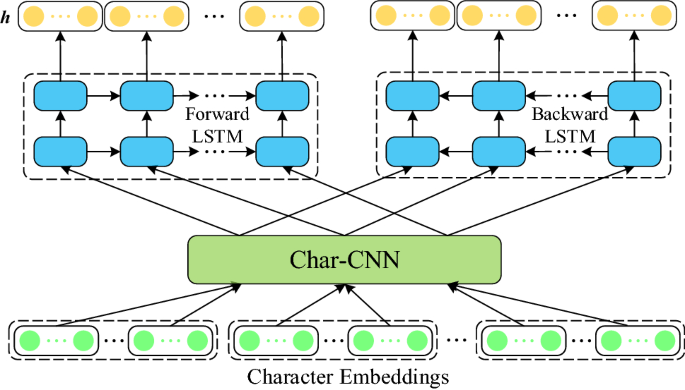


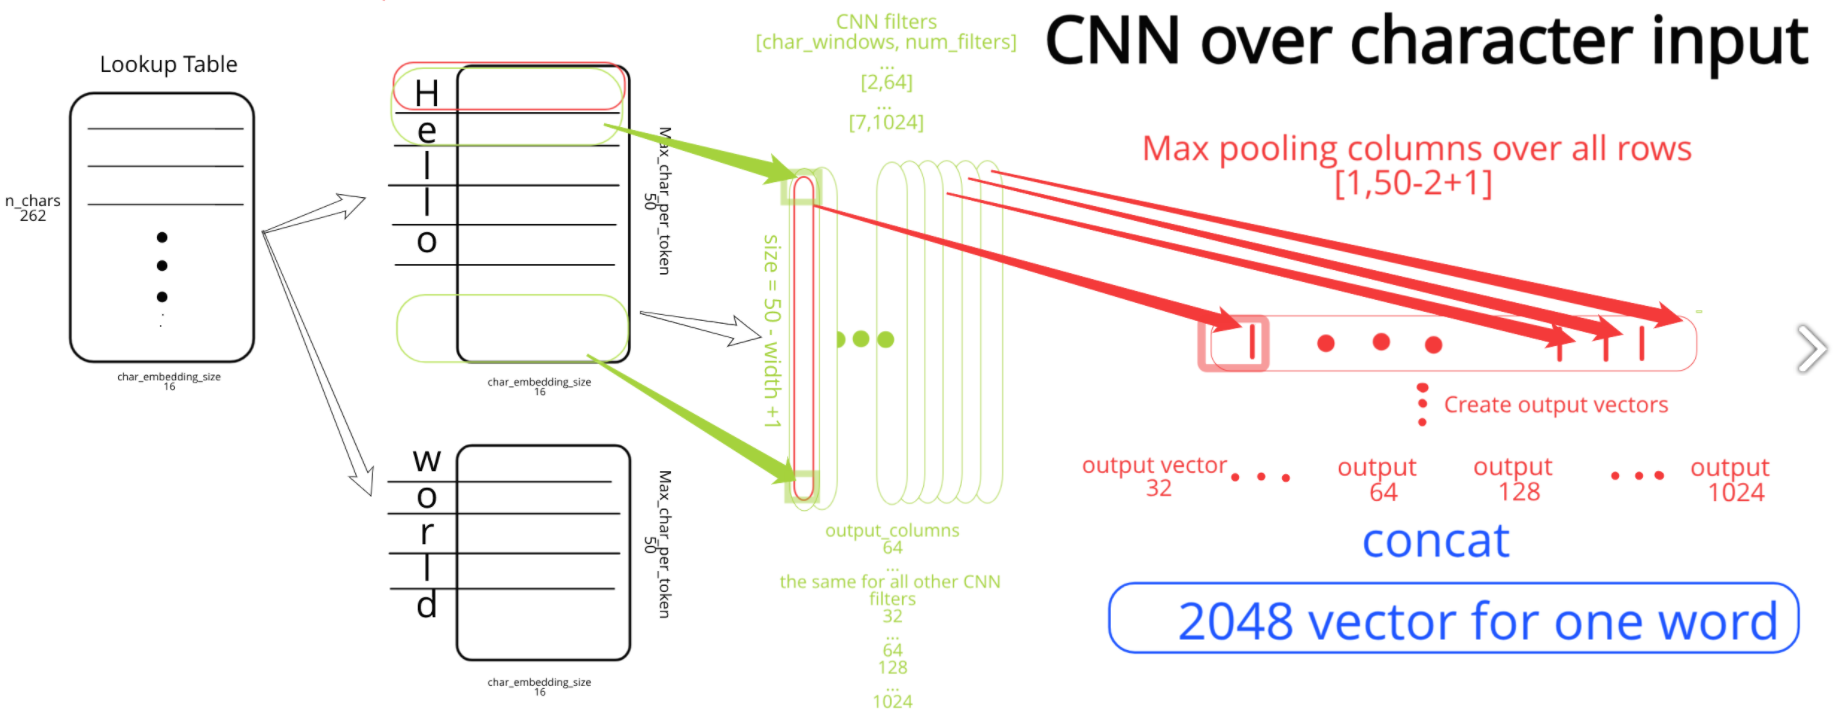

In [125]:
!ls

dataset_stage2.zip  SEqlab.ipynb	 train_clean.csv   train.tsv
dev.tsv		    test_no_answers.tsv  train_clean.xlsx


In [127]:
from allennlp.data.dataset_readers import Conll2003DatasetReader
from allennlp.data.token_indexers import ELMoTokenCharactersIndexer

token_indexer = ELMoTokenCharactersIndexer()
reader = SeqDatasetReader(token_indexers={'elmo_tokens': token_indexer})

train_dataset = reader.read('train.tsv')
dev_dataset = reader.read('dev.tsv')
#test_dataset = reader.read('test_no_answers.tsv')


reading instances: 0it [00:00, ?it/s]
reading instances: 2334it [00:00, 13577.49it/s]

reading instances: 283it [00:00, 10790.41it/s]


In [128]:
from allennlp.data.vocabulary import Vocabulary

vocab = Vocabulary.from_instances(train_dataset.instances)
train_dataset.index_with(vocab)
dev_dataset.index_with(vocab)
test_dataset.index_with(vocab)


building vocab: 100%|##########| 2334/2334 [00:00<00:00, 83756.89it/s]


In [129]:
from allennlp.modules.token_embedders import ElmoTokenEmbedder

elmo_embedder = ElmoTokenEmbedder()
text_field_embedder = BasicTextFieldEmbedder({"elmo_tokens": elmo_embedder})


downloading: 100%|##########| 336/336 [00:00<00:00, 820306.25B/s]

downloading: 100%|##########| 374434792/374434792 [00:10<00:00, 36149138.23B/s]
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [130]:
elmo_embedder

ElmoTokenEmbedder(
  (_elmo): Elmo(
    (_elmo_lstm): _ElmoBiLm(
      (_token_embedder): _ElmoCharacterEncoder(
        (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
        (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
        (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
        (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
        (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
        (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
        (_highways): Highway(
          (_layers): ModuleList(
            (0): Linear(in_features=2048, out_features=4096, bias=True)
            (1): Linear(in_features=2048, out_features=4096, bias=True)
          )
        )
        (_projection): Linear(in_features=2048, out_features=512, bias=True)
      )
      (_elmo_lstm): ElmoLstm(
        (forward_layer_0): LstmCellWithProjection(
    

In [131]:
from allennlp_models.tagging import CrfTagger
from allennlp.modules.seq2seq_encoders.pytorch_seq2seq_wrapper import LstmSeq2SeqEncoder


encoder = LstmSeq2SeqEncoder(input_size=elmo_embedder.get_output_dim(), 
                             hidden_size=200, bidirectional=True)

model = CrfTagger(text_field_embedder=text_field_embedder, 
                  vocab=vocab, 
                  encoder=encoder,
                  calculate_span_f1=True,
                  label_encoding='IOB1').cuda(device=cuda_device)

In [133]:
from datetime import datetime
from allennlp.training.learning_rate_schedulers import ReduceOnPlateauLearningRateScheduler
from allennlp.training import GradientDescentTrainer


optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=0.001)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=8, 
                               collate_fn=allennlp_collate, shuffle=True)
dev_data_loader = DataLoader(dataset=dev_dataset, batch_size=100, collate_fn=allennlp_collate)
lr_scheduler = ReduceOnPlateauLearningRateScheduler(optimizer, patience=1, factor=0.5)

date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')

trainer = GradientDescentTrainer(
    model=model,
    #serialization_dir=f'./workdir/{date_str}/{time_str}',
    data_loader=train_data_loader,
    validation_data_loader=dev_data_loader,
    num_epochs=10,
    optimizer=optimizer,
    cuda_device=cuda_device,
    learning_rate_scheduler=lr_scheduler,
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")

  0%|          | 0/292 [00:00<?, ?it/s]
accuracy: 0.0087, accuracy3: 0.0693, precision-overall: 0.0071, recall-overall: 0.0250, f1-measure-overall: 0.0111, batch_loss: 429.6931, loss: 429.6931 ||:   0%|          | 1/292 [00:00<01:33,  3.11it/s]
accuracy: 0.3589, accuracy3: 0.4067, precision-overall: 0.0071, recall-overall: 0.0132, f1-measure-overall: 0.0093, batch_loss: 238.8315, loss: 334.2623 ||:   1%|          | 2/292 [00:00<01:26,  3.36it/s]
accuracy: 0.2688, accuracy3: 0.3189, precision-overall: 0.0343, recall-overall: 0.0948, f1-measure-overall: 0.0503, batch_loss: 1550.1687, loss: 739.5644 ||:   1%|1         | 3/292 [00:00<01:19,  3.62it/s]
accuracy: 0.4216, accurac

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=100, collate_fn=allennlp_collate)
evaluate(model, test_dataloader, cuda_device=0)

In [ ]:
predictor = SentenceTaggerPredictor(model, reader)
preds = predictor.predict('We are living in New York')
list(zip(preds['words'], preds['tags']))

## 4.6 Pre-trained contextual embeddings. BERT and other Transformers

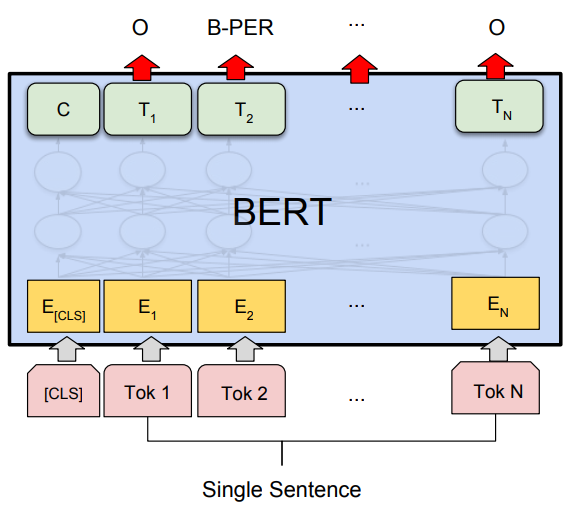

In [134]:
from allennlp.data.token_indexers import PretrainedTransformerMismatchedIndexer
from allennlp.data.vocabulary import Vocabulary


BERT_MODEL = 'bert-base-cased'
indexer = PretrainedTransformerMismatchedIndexer(model_name=BERT_MODEL)

In [135]:
wordpieces, offsets = indexer._allennlp_tokenizer.intra_word_tokenize(['We', 'are', 'living', 'in', 'Mönchengladbach'])
wordpieces

[[CLS], We, are, living, in, Mon, ##cheng, ##lad, ##bach, [SEP]]

In [137]:
reader = SeqDatasetReader(token_indexers={'tokens': indexer})
train_dataset = reader.read('train.tsv')
dev_dataset = reader.read('dev.tsv')
#test_dataset = reader.read('test_no_answers.tsv')


reading instances: 0it [00:00, ?it/s]
reading instances: 2334it [00:00, 14635.84it/s]

reading instances: 283it [00:00, 11191.45it/s]


In [138]:
vocab = Vocabulary.from_instances(train_dataset.instances)
train_dataset.index_with(vocab)
dev_dataset.index_with(vocab)
test_dataset.index_with(vocab)


building vocab: 100%|##########| 2334/2334 [00:00<00:00, 61105.74it/s]


In [139]:
from allennlp.modules.token_embedders import PretrainedTransformerMismatchedEmbedder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.seq2seq_encoders import PassThroughEncoder


embedder = PretrainedTransformerMismatchedEmbedder(model_name=BERT_MODEL)
text_field_embedder = BasicTextFieldEmbedder({'tokens': embedder})
seq2seq_encoder = PassThroughEncoder(input_dim=embedder.get_output_dim())

In [140]:
embedder

PretrainedTransformerMismatchedEmbedder(
  (_matched_embedder): PretrainedTransformerEmbedder(
    (transformer_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense):

In [141]:
from allennlp.models import SimpleTagger


model = SimpleTagger(text_field_embedder=text_field_embedder, 
                      vocab=vocab, 
                      encoder=seq2seq_encoder,
                      calculate_span_f1=True,
                      label_encoding='IOB1').cuda(device=cuda_device)

In [143]:
import torch.optim as optim
from transformers import AdamW
import transformers
from datetime import datetime

from allennlp.training.learning_rate_schedulers import LinearWithWarmup
from torch.utils.data import DataLoader
from allennlp.training import GradientDescentTrainer
from allennlp.training.learning_rate_schedulers import SlantedTriangular

import math


num_epochs = 4
batch_size = 16
steps_per_epoch = math.ceil(len(train_dataset) / batch_size)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                               collate_fn=allennlp_collate, shuffle=True)
val_data_loader = DataLoader(dataset=dev_dataset, batch_size=100, collate_fn=allennlp_collate)
lr_scheduler = LinearWithWarmup(optimizer, 
                                num_epochs=num_epochs, 
                                warmup_steps=(steps_per_epoch*num_epochs)*0.1, 
                                num_steps_per_epoch=steps_per_epoch)

date_time = datetime.now()
date_str = date_time.strftime('%m/%d/%Y')
time_str = date_time.strftime('%H:%M:%S')


trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=train_data_loader,
    validation_data_loader=val_data_loader,
    num_epochs=num_epochs,
    cuda_device=cuda_device,
    learning_rate_scheduler=lr_scheduler,
    num_gradient_accumulation_steps=1,
    #serialization_dir=f'./workdir/{date_str}/{time_str}',
    grad_clipping=1.
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled

  0%|          | 0/146 [00:00<?, ?it/s]
accuracy: 0.4853, accuracy3: 0.8420, precision-overall: 0.0787, recall-overall: 0.1647, f1-measure-overall: 0.1065, batch_loss: 1.7034, loss: 1.7034 ||:   1%|          | 1/146 [00:00<00:51,  2.83it/s]
accuracy: 0.5263, accuracy3: 0.8468, precision-overall: 0.0737, recall-overall: 0.1484, f1-measure-overall: 0.0985, batch_loss: 1.6627, loss: 1.6830 ||:   1%|1         | 2/146 [00:00<00:48,  2.97it/s]
accuracy: 0.5292, accuracy3: 0.8533, precision-overall: 0.0660, recall-overall: 0.1368, f1-measure-overall: 0.0890, batch_loss: 1.6741, loss: 1.6800 ||:   2%|2         | 3/146 [00:00<00:46,  3.07it/s]
accuracy: 0.5381, accuracy3: 0.8602, precision-overall: 0.0614, recall-overall: 0.1217, f1-measure-overall: 0.0816, batch_loss: 1.6604, loss: 1.6751 ||:   3%|2         | 4/146 [00:01<00:44,  3.17it/s]
accuracy: 0.5601, accuracy3: 0.8653, precision-over

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=100, collate_fn=allennlp_collate)
evaluate(model, test_dataloader, cuda_device=0)

In [144]:
predictor = SentenceTaggerPredictor(model, reader)
preds = predictor.predict('We are living in New York')
list(zip(preds['words'], preds['tags']))

[('We', 'O'),
 ('are', 'O'),
 ('living', 'O'),
 ('in', 'O'),
 ('New', 'O'),
 ('York', 'O')]

# Final remarks

MSc research project  
**"Active Learning in the Sequence Tagging Tasks using Deep Pre-trained Models and Bayesian Uncertainty Estimates"**

Dr. Artem Shelmanov

A.Shelmanov@skoltech.ru